# Baseline Random Forest Classifier

This notebook builds and evaluates a baseline Random Forest classifier for soccer match prediction: Over/Under 2.5 goals (binary classification).

## Structure:
- **#0**: Setup and Data Loading
- **#1**: Baseline Model Training
- **#2**: Hyperparameter Tuning
- **#3**: Feature Importance Analysis
- **#4**: Learning Curves
- **#5**: Final Evaluation on Test Set

## #0: Setup and Data Loading

### #0.1: Import Required Libraries
Import all necessary libraries for model training, evaluation, and visualization.

In [ ]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, log_loss, confusion_matrix, classification_report)
from sklearn.model_selection import learning_curve,  cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
import optuna
from optuna.samplers import TPESampler
import time
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

### #0.2: Load Preprocessed Data
Load the baseline preprocessed data containing training, validation, and test sets.

In [ ]:
with open('./outputs/processed/baseline_preprocessed.pkl', 'rb') as file:
    data = pickle.load(file)

X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']
X_test = data['X_test']
y_test = data['y_test']

In [ ]:
# Check data shapes
print(f"Training set: X={X_train.shape}, y={y_train.shape}")
print(f"Validation set: X={X_val.shape}, y={y_val.shape}")
print(f"Test set: X={X_test.shape}, y={y_test.shape}")
print(f"\nClass distribution in training set:")
class_dist = pd.Series(y_train).value_counts(normalize=True).sort_index()
class_names = {0: 'Under 2.5 goals', 1: 'Over 2.5 goals'}
for idx, val in class_dist.items():
    print(f"{class_names[idx]}: {val:.4f}")

Training set: X=(28217, 344), y=(28217,)
Validation set: X=(7247, 344), y=(7247,)
Test set: X=(7129, 344), y=(7129,)

Class distribution in training set:
Under 2.5 goals: 0.5100
Over 2.5 goals: 0.4900


## #1: Baseline Model Training

### #1.1: Train Baseline Random Forest
Train an untuned Random Forest classifier with default parameters on the training set.

In [8]:
# Train baseline Random Forest with default parameters
baseline_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("Training baseline Random Forest...")
baseline_rf.fit(X_train, y_train)
print("Training completed!")

Training baseline Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.3s


Training completed!


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished


### #1.2: Evaluate Baseline Model on Validation Set
Generate predictions and calculate performance metrics on the validation set.

In [9]:
def evaluate_model(model, X, y, dataset_name="Dataset"):
    """
    Evaluate model and return comprehensive metrics.
    """
    # Predictions
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    # Calculate metrics
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y, y_pred, average='weighted', zero_division=0)
    
    # ROC-AUC for binary classification
    try:
        roc_auc = roc_auc_score(y, y_pred_proba[:, 1])
    except:
        roc_auc = None
    
    # Log Loss (cross-entropy) - lower is better
    try:
        logloss = log_loss(y, y_pred_proba)
    except:
        logloss = None
    
    print(f"\n{'='*60}")
    print(f"Performance Metrics - {dataset_name}")
    print(f"{'='*60}")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    if roc_auc:
        print(f"ROC-AUC:   {roc_auc:.4f}")
    if logloss is not None:
        print(f"Log Loss:  {logloss:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y, y_pred)
    print(f"\nConfusion Matrix:")
    print(cm)
    
    # Classification Report
    print(f"\nClassification Report:")
    print(classification_report(y, y_pred, target_names=['Under 2.5', 'Over 2.5'], zero_division=0))
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'log_loss': logloss,
        'confusion_matrix': cm,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

In [10]:
# Evaluate on validation set
baseline_val_results = evaluate_model(baseline_rf, X_val, y_val, "Baseline - Validation Set")


Performance Metrics - Baseline - Validation Set
Accuracy:  0.5525
Precision: 0.5569
Recall:    0.5525
F1-Score:  0.5525
ROC-AUC:   0.5796
Log Loss:  0.6834

Confusion Matrix:
[[2003 1393]
 [1850 2001]]

Classification Report:
              precision    recall  f1-score   support

   Under 2.5       0.52      0.59      0.55      3396
    Over 2.5       0.59      0.52      0.55      3851

    accuracy                           0.55      7247
   macro avg       0.55      0.55      0.55      7247
weighted avg       0.56      0.55      0.55      7247



[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished


### #1.3: Visualize Confusion Matrix
Create a heatmap visualization of the confusion matrix for the validation set.

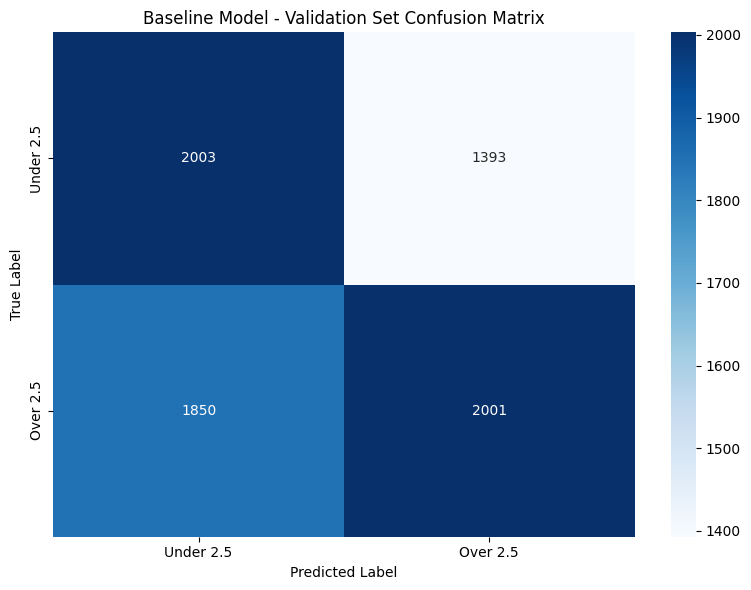

In [11]:
def plot_confusion_matrix(cm, title="Confusion Matrix"):
    """
    Plot confusion matrix as a heatmap.
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Under 2.5', 'Over 2.5'],
                yticklabels=['Under 2.5', 'Over 2.5'])
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(baseline_val_results['confusion_matrix'], 
                     "Baseline Model - Validation Set Confusion Matrix")

## #2: Hyperparameter Tuning

### #2.1: Bayesian Optimization with Optuna
Use Optuna to perform Bayesian optimization to find optimal hyperparameters.

In [12]:
def objective(trial):
    """
    Objective function for Optuna hyperparameter optimization.
    Uses validation set to evaluate performance.
    Returns: Log Loss to minimize (penalizes confident incorrect predictions)
    """
    # Define hyperparameter search space
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': 42,
        'n_jobs': -1
    }
    
    # Create model with suggested hyperparameters
    model = RandomForestClassifier(**params)
    
    # Train on training set and evaluate on validation set
    model.fit(X_train, y_train)
    y_val_pred_proba = model.predict_proba(X_val)
    val_logloss = log_loss(y_val, y_val_pred_proba)
    
    return val_logloss

# Create study and optimize
print("Starting Bayesian Optimization with Optuna...")
print("Using validation set for hyperparameter evaluation...")
print("Optimizing Log Loss (lower is better, penalizes confident incorrect predictions)...")
study = optuna.create_study(
    direction='minimize',
    sampler=TPESampler(seed=42),
    study_name='random_forest_optuna'
)

# Record start time
start_time = time.time()

study.optimize(objective, n_trials=150, show_progress_bar=True)

# Calculate optimization time
optimization_time = time.time() - start_time

print(f"\nOptimization completed in {optimization_time:.1f} seconds")
print(f"Best Validation Log Loss: {study.best_value:.6f}")
print(f"Best trial: #{study.best_trial.number}")
print(f"\nBest hyperparameters:")
for key, value in study.best_trial.params.items():
    print(f"  {key}: {value}")

[I 2025-11-16 12:30:14,801] A new study created in memory with name: random_forest_optuna


Starting Bayesian Optimization with Optuna...
Using validation set for hyperparameter evaluation...
Optimizing Log Loss (lower is better, penalizes confident incorrect predictions)...


Best trial: 0. Best value: 0.689733:   1%|          | 1/150 [00:03<08:15,  3.32s/it]

[I 2025-11-16 12:30:18,126] Trial 0 finished with value: 0.6897332339350732 and parameters: {'n_estimators': 250, 'max_depth': 29, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.6897332339350732.


Best trial: 1. Best value: 0.684161:   1%|▏         | 2/150 [00:05<06:23,  2.59s/it]

[I 2025-11-16 12:30:20,199] Trial 1 finished with value: 0.6841605237499288 and parameters: {'n_estimators': 383, 'max_depth': 5, 'min_samples_split': 20, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: 0.6841605237499288.


Best trial: 1. Best value: 0.684161:   1%|▏         | 2/150 [00:09<11:13,  4.55s/it]


[W 2025-11-16 12:30:23,892] Trial 2 failed with parameters: {'n_estimators': 273, 'max_depth': 12, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/ozetek/Documents/Škola/5. semestr/ML2/soccer-leagues-predictions/.venv/lib/python3.13/site-packages/optuna/study/_optimize.py", line 205, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/5k/xsh6xzj10l121lg2lr_6rpkm0000gn/T/ipykernel_7146/2126451287.py", line 23, in objective
    model.fit(X_train, y_train)
    ~~~~~~~~~^^^^^^^^^^^^^^^^^^
  File "/Users/ozetek/Documents/Škola/5. semestr/ML2/soccer-leagues-predictions/.venv/lib/python3.13/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/ozetek/Documents/Škola/5. semestr/ML2/soccer-leagues-predictions/.venv/lib/python3.13/site-packages/sklearn/ensemble/_forest.p

KeyboardInterrupt: 

### #2.2: Manual Bayesian Optimization with Gaussian Processes
Implement Bayesian optimization from scratch using Gaussian Processes as surrogate model and UCB acquisition function.

In [ ]:
# --------------------------------------------
#  Define objective function for manual BO
# --------------------------------------------
def evaluate_rf_manual(params):
    """
    Evaluate Random Forest with given hyperparameters using validation set.
    Returns: Log Loss to minimize (penalizes confident incorrect predictions)
    """
    # Handle max_features categorical parameter (encoded as continuous for GP)
    max_features_map = {0: 'sqrt', 1: 'log2', 2: None}
    max_features_idx = int(round(params[4]))
    max_features_idx = np.clip(max_features_idx, 0, 2)  # Ensure valid range
    max_features_val = max_features_map[max_features_idx]
    
    # Handle bootstrap boolean (encoded as continuous for GP)
    bootstrap_val = bool(params[5] > 0.5)
    
    model = RandomForestClassifier(
        n_estimators=int(params[0]),
        max_depth=int(params[1]),
        min_samples_split=int(params[2]),
        min_samples_leaf=int(params[3]),
        max_features=max_features_val,
        bootstrap=bootstrap_val,
        random_state=42,
        n_jobs=-1
    )
    
    # Train on training set and evaluate on validation set
    model.fit(X_train, y_train)
    y_val_pred_proba = model.predict_proba(X_val)
    val_logloss = log_loss(y_val, y_val_pred_proba)
    
    # Return log loss (already a minimization metric)
    return val_logloss

# --------------------------------------------
#  Define search space bounds
# --------------------------------------------
param_bounds = np.array([
    [100, 500],      # n_estimators: 100-500
    [5, 30],         # max_depth: 5-30
    [2, 20],         # min_samples_split: 2-20
    [1, 10],         # min_samples_leaf: 1-10
    [0, 2],          # max_features: 0='sqrt', 1='log2', 2=None
    [0, 1],          # bootstrap: 0=False, 1=True (continuous for GP)
])

n_params = param_bounds.shape[0]

# --------------------------------------------
#  Initialize samples (random warm-up phase)
# --------------------------------------------
np.random.seed(42)
N_INIT = 20  # Initial random samples to warm up the GP

print("🔧 Initializing Manual Bayesian Optimization...")
print(f"Generating {N_INIT} random initial samples...")

X_samples = np.random.uniform(param_bounds[:, 0], param_bounds[:, 1], size=(N_INIT, n_params))
Y_samples = np.array([evaluate_rf_manual(x) for x in X_samples])

print(f"Initial samples generated. Best initial Validation Log Loss: {np.min(Y_samples):.6f}")

# --------------------------------------------
#  Fit Gaussian Process surrogate model
# --------------------------------------------
kernel = Matern(length_scale=1.0, nu=2.5)
gp = GaussianProcessRegressor(
    kernel=kernel,
    normalize_y=True,
    n_restarts_optimizer=3,
    random_state=42
)

# Normalize features for better GP performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_samples)
gp.fit(X_scaled, Y_samples)

# --------------------------------------------
#  Acquisition function (Upper Confidence Bound)
# --------------------------------------------
def acquisition_ucb(X, model, kappa=2.0):
    """
    Upper Confidence Bound acquisition function.
    Since we're minimizing Log Loss, we use LCB (Lower Confidence Bound).
    
    LCB = mu - kappa * sigma (for minimization)
    """
    mu, sigma = model.predict(X, return_std=True)
    return mu - kappa * sigma  # Lower is better for minimization

def propose_next(model, bounds, scaler, n_candidates=2000):
    """Propose next point to evaluate using acquisition function"""
    candidates = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_candidates, bounds.shape[0]))
    candidates_scaled = scaler.transform(candidates)
    acq_vals = acquisition_ucb(candidates_scaled, model)
    best_idx = np.argmin(acq_vals)
    return candidates[best_idx].reshape(1, -1)

# --------------------------------------------
#  Bayesian Optimization loop
# --------------------------------------------
N_ITER = 130  # Number of BO iterations (150 total evaluations = 20 init + 130 iterations)
history_best = [np.min(Y_samples)]

print(f"\nStarting Bayesian Optimization loop with {N_ITER} iterations...")
start_time = time.time()

for i in range(N_ITER):
    # Propose next point using acquisition function
    x_next = propose_next(gp, param_bounds, scaler)
    y_next = evaluate_rf_manual(x_next[0])
    
    # Update dataset
    X_samples = np.vstack([X_samples, x_next])
    Y_samples = np.hstack([Y_samples, y_next])
    
    # Refit Gaussian Process
    X_scaled = scaler.fit_transform(X_samples)
    gp.fit(X_scaled, Y_samples)
    
    # Track progress
    history_best.append(np.min(Y_samples))
    current_best_logloss = np.min(Y_samples)
    current_logloss = y_next
    
    # Print every iteration to see progress
    if (i + 1) % 5 == 0 or i < 5:
        print(f"Iteration {i+1:02d}/{N_ITER}: Current Val Log Loss = {current_logloss:.6f}, Best Val Log Loss = {current_best_logloss:.6f}")

optimization_time = time.time() - start_time

# --------------------------------------------
#  Extract best parameters
# --------------------------------------------
best_idx = np.argmin(Y_samples)
best_params_array = X_samples[best_idx]
best_logloss_manual = Y_samples[best_idx]

# Convert to dictionary format
max_features_map = {0: 'sqrt', 1: 'log2', 2: None}
manual_bo_params = {
    'n_estimators': int(best_params_array[0]),
    'max_depth': int(best_params_array[1]),
    'min_samples_split': int(best_params_array[2]),
    'min_samples_leaf': int(best_params_array[3]),
    'max_features': max_features_map[int(round(np.clip(best_params_array[4], 0, 2)))],
    'bootstrap': bool(best_params_array[5] > 0.5),
}

print(f"\nManual Bayesian Optimization completed in {optimization_time:.1f} seconds")
print(f"Best Validation Log Loss: {best_logloss_manual:.6f}")
print(f"Total evaluations: {len(Y_samples)}")
print(f"\nBest hyperparameters found:")
for name, val in manual_bo_params.items():
    print(f"  {name}: {val}")

🔧 Initializing Manual Bayesian Optimization...
Generating 10 random initial samples...
Initial samples generated. Best initial Validation Log Loss: 0.682885

Starting Bayesian Optimization loop with 40 iterations...
Iteration 01/40: Current Val Log Loss = 0.683350, Best Val Log Loss = 0.682885
Iteration 02/40: Current Val Log Loss = 0.683253, Best Val Log Loss = 0.682885
Iteration 03/40: Current Val Log Loss = 0.684223, Best Val Log Loss = 0.682885
Iteration 04/40: Current Val Log Loss = 0.683848, Best Val Log Loss = 0.682885
Iteration 05/40: Current Val Log Loss = 0.682849, Best Val Log Loss = 0.682849
Iteration 10/40: Current Val Log Loss = 0.684313, Best Val Log Loss = 0.682849
Iteration 15/40: Current Val Log Loss = 0.684192, Best Val Log Loss = 0.682849
Iteration 20/40: Current Val Log Loss = 0.683394, Best Val Log Loss = 0.682849
Iteration 25/40: Current Val Log Loss = 0.684125, Best Val Log Loss = 0.682849
Iteration 30/40: Current Val Log Loss = 0.683671, Best Val Log Loss = 0.6

### #2.3: Compare Optimization Methods
Compare the performance of Optuna vs Manual Bayesian Optimization.


HYPERPARAMETER OPTIMIZATION COMPARISON

🔹 Optuna Optimization:
   Best Validation Log Loss: 0.682275
   Total evaluations: 150

🔹 Manual Bayesian Optimization:
   Best Validation Log Loss: 0.682849
   Total evaluations: 50

🔹 Difference:
   Optuna is better by 0.000575 (lower is better)


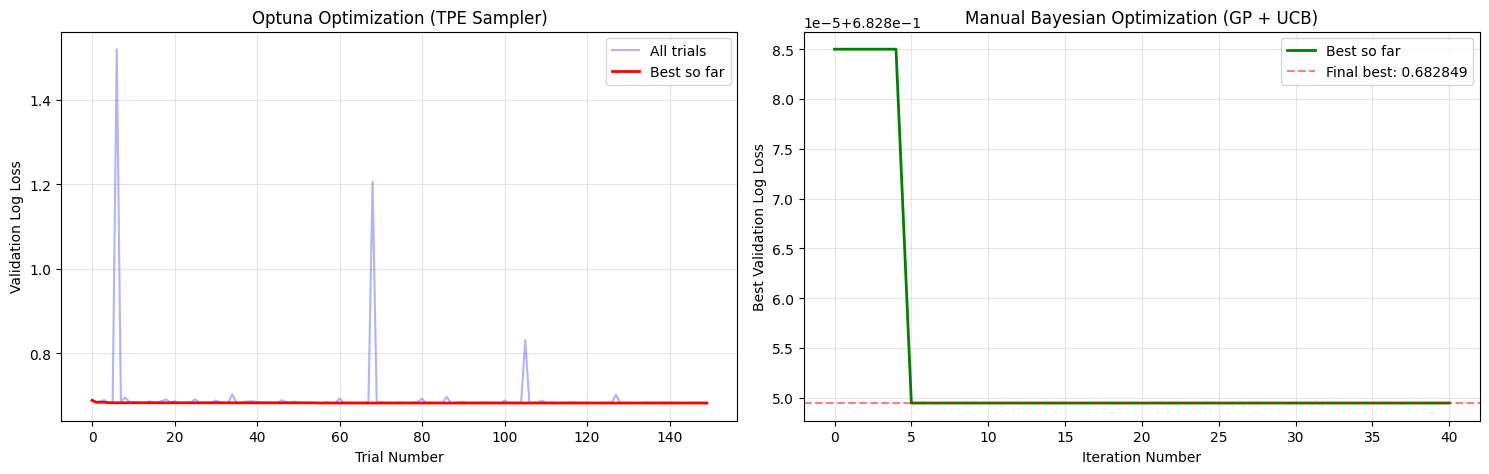


📊 Best Hyperparameters Comparison:
Parameter            Optuna               Manual BO           
------------------------------------------------------------
n_estimators         346                  491                 
max_depth            8                    8                   
min_samples_split    19                   12                  
min_samples_leaf     4                    1                   
max_features         log2                 log2                
bootstrap            False                False               


In [ ]:
# Compare Optuna and Manual BO results
print("\n" + "="*70)
print("HYPERPARAMETER OPTIMIZATION COMPARISON")
print("="*70)

print(f"\n🔹 Optuna Optimization:")
print(f"   Best Validation Log Loss: {study.best_value:.6f}")
print(f"   Total evaluations: {len(study.trials)}")

print(f"\n🔹 Manual Bayesian Optimization:")
print(f"   Best Validation Log Loss: {best_logloss_manual:.6f}")
print(f"   Total evaluations: {len(Y_samples)}")

print(f"\n🔹 Difference:")
diff = study.best_value - best_logloss_manual
if diff < 0:
    print(f"   Optuna is better by {abs(diff):.6f} (lower is better)")
else:
    print(f"   Manual BO is better by {diff:.6f} (lower is better)")
print("="*70)

# Visualize optimization convergence
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Optuna optimization history
trials_df = study.trials_dataframe()
axes[0].plot(trials_df['number'], trials_df['value'], 'b-', alpha=0.3, label='All trials')
axes[0].plot(trials_df['number'], trials_df['value'].cummin(), 'r-', linewidth=2, label='Best so far')
axes[0].set_xlabel('Trial Number')
axes[0].set_ylabel('Validation Log Loss')
axes[0].set_title('Optuna Optimization (TPE Sampler)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Manual BO convergence
manual_best_curve = history_best  # Already in Log Loss (no conversion needed)
axes[1].plot(range(len(manual_best_curve)), manual_best_curve, 'g-', linewidth=2, label='Best so far')
axes[1].axhline(y=manual_best_curve[-1], color='r', linestyle='--', alpha=0.5, label=f'Final best: {manual_best_curve[-1]:.6f}')
axes[1].set_xlabel('Iteration Number')
axes[1].set_ylabel('Best Validation Log Loss')
axes[1].set_title('Manual Bayesian Optimization (GP + UCB)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Compare parameter distributions
print("\n📊 Best Hyperparameters Comparison:")
print(f"{'Parameter':<20} {'Optuna':<20} {'Manual BO':<20}")
print("-" * 60)
for param in ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'max_features', 'bootstrap']:
    optuna_val = study.best_params.get(param, 'N/A')
    manual_val = manual_bo_params.get(param, 'N/A')
    print(f"{param:<20} {str(optuna_val):<20} {str(manual_val):<20}")

### #2.4: Train Optimized Models
Train models with best parameters from both Optuna and Manual BO, then evaluate on validation set.

In [ ]:
# Train model with Optuna best parameters
print("🔹 Training model with Optuna best parameters...")
rf_optuna = RandomForestClassifier(
    **study.best_params,
    random_state=42,
    n_jobs=-1
)
rf_optuna.fit(X_train, y_train)

# Evaluate on validation set
y_val_pred_optuna = rf_optuna.predict(X_val)
y_val_pred_proba_optuna = rf_optuna.predict_proba(X_val)
val_logloss_optuna = log_loss(y_val, y_val_pred_proba_optuna)
print(f"   Validation Log Loss: {val_logloss_optuna:.6f}")

# Train model with Manual BO best parameters
print("\n🔹 Training model with Manual BO best parameters...")
rf_manual = RandomForestClassifier(
    **manual_bo_params,
    random_state=42,
    n_jobs=-1
)
rf_manual.fit(X_train, y_train)

# Evaluate on validation set
y_val_pred_manual = rf_manual.predict(X_val)
y_val_pred_proba_manual = rf_manual.predict_proba(X_val)
val_logloss_manual = log_loss(y_val, y_val_pred_proba_manual)
print(f"   Validation Log Loss: {val_logloss_manual:.6f}")

print("\n📊 Validation Set Results:")
print(f"{'Model':<25} {'Optimization Val Log Loss':<30} {'Final Val Log Loss':<20}")
print("-" * 75)
print(f"{'Baseline RF':<25} {'N/A':<30} {baseline_val_results['log_loss']:<20.6f}")
print(f"{'Optuna Optimized':<25} {study.best_value:<30.6f} {val_logloss_optuna:<20.6f}")
print(f"{'Manual BO Optimized':<25} {best_logloss_manual:<30.6f} {val_logloss_manual:<20.6f}")

🔹 Training model with Optuna best parameters...
   Validation Log Loss: 0.682275

🔹 Training model with Manual BO best parameters...
   Validation Log Loss: 0.682849

📊 Validation Set Results:
Model                     Optimization Val Log Loss      Final Val Log Loss  
---------------------------------------------------------------------------
Baseline RF               N/A                            0.683520            
Optuna Optimized          0.682275                       0.682275            
Manual BO Optimized       0.682849                       0.682849            


### #2.5: Compare All Models on Validation Set
Comprehensive comparison of Baseline vs Optuna vs Manual BO models.

In [ ]:
# Evaluate all models comprehensively
print("\n" + "="*70)
print("COMPREHENSIVE MODEL COMPARISON - VALIDATION SET")
print("="*70)

# Optuna model
optuna_val_results = evaluate_model(rf_optuna, X_val, y_val, "Optuna Optimized - Validation")

# Manual BO model
manual_val_results = evaluate_model(rf_manual, X_val, y_val, "Manual BO Optimized - Validation")

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'Log Loss'],
    'Baseline': [
        baseline_val_results['accuracy'],
        baseline_val_results['precision'],
        baseline_val_results['recall'],
        baseline_val_results['f1'],
        baseline_val_results['roc_auc'],
        baseline_val_results['log_loss']
    ],
    'Optuna': [
        optuna_val_results['accuracy'],
        optuna_val_results['precision'],
        optuna_val_results['recall'],
        optuna_val_results['f1'],
        optuna_val_results['roc_auc'],
        optuna_val_results['log_loss']
    ],
    'Manual BO': [
        manual_val_results['accuracy'],
        manual_val_results['precision'],
        manual_val_results['recall'],
        manual_val_results['f1'],
        manual_val_results['roc_auc'],
        manual_val_results['log_loss']
    ]
})

# Calculate improvement percentages
# For most metrics, higher is better, so positive % is good
# For Log Loss, lower is better, so we invert the calculation
comparison_df['Optuna Improvement (%)'] = ((comparison_df['Optuna'] - comparison_df['Baseline']) / comparison_df['Baseline'] * 100).round(2)
comparison_df['Manual BO Improvement (%)'] = ((comparison_df['Manual BO'] - comparison_df['Baseline']) / comparison_df['Baseline'] * 100).round(2)

# For Log Loss, invert the improvement calculation (reduction is improvement)
log_loss_idx = comparison_df['Metric'] == 'Log Loss'
comparison_df.loc[log_loss_idx, 'Optuna Improvement (%)'] = (
    ((comparison_df.loc[log_loss_idx, 'Baseline'].values - comparison_df.loc[log_loss_idx, 'Optuna'].values) / 
     comparison_df.loc[log_loss_idx, 'Baseline'].values * 100).round(2)[0]
)
comparison_df.loc[log_loss_idx, 'Manual BO Improvement (%)'] = (
    ((comparison_df.loc[log_loss_idx, 'Baseline'].values - comparison_df.loc[log_loss_idx, 'Manual BO'].values) / 
     comparison_df.loc[log_loss_idx, 'Baseline'].values * 100).round(2)[0]
)

print("\n" + "="*80)
print("Baseline vs Optimized Models Comparison (Validation Set)")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)


COMPREHENSIVE MODEL COMPARISON - VALIDATION SET

Performance Metrics - Optuna Optimized - Validation
Accuracy:  0.5561
Precision: 0.5615
Recall:    0.5561
F1-Score:  0.5557
ROC-AUC:   0.5837
Log Loss:  0.6823

Confusion Matrix:
[[2058 1338]
 [1879 1972]]

Classification Report:
              precision    recall  f1-score   support

   Under 2.5       0.52      0.61      0.56      3396
    Over 2.5       0.60      0.51      0.55      3851

    accuracy                           0.56      7247
   macro avg       0.56      0.56      0.56      7247
weighted avg       0.56      0.56      0.56      7247


Performance Metrics - Manual BO Optimized - Validation
Accuracy:  0.5566
Precision: 0.5626
Recall:    0.5566
F1-Score:  0.5560
ROC-AUC:   0.5823
Log Loss:  0.6828

Confusion Matrix:
[[2078 1318]
 [1895 1956]]

Classification Report:
              precision    recall  f1-score   support

   Under 2.5       0.52      0.61      0.56      3396
    Over 2.5       0.60      0.51      0.55      3

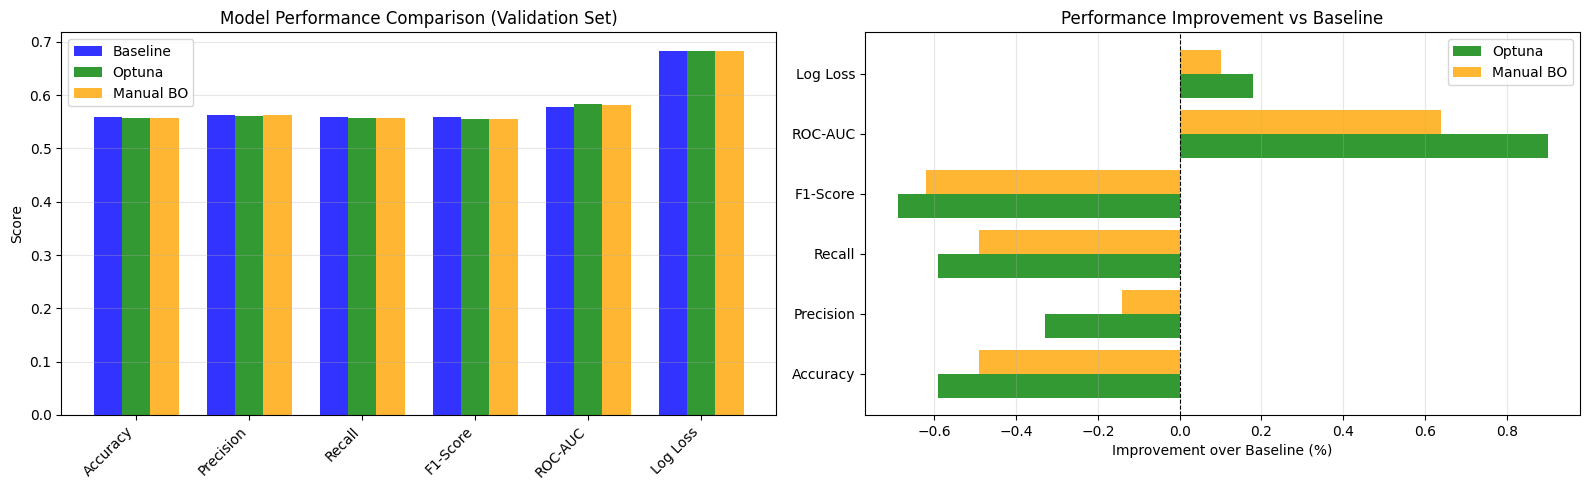

In [ ]:
# Visualize comparison of all three models
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Bar plot comparison
metrics = comparison_df['Metric'].tolist()
x = np.arange(len(metrics))
width = 0.25

axes[0].bar(x - width, comparison_df['Baseline'], width, label='Baseline', alpha=0.8, color='blue')
axes[0].bar(x, comparison_df['Optuna'], width, label='Optuna', alpha=0.8, color='green')
axes[0].bar(x + width, comparison_df['Manual BO'], width, label='Manual BO', alpha=0.8, color='orange')
axes[0].set_ylabel('Score')
axes[0].set_title('Model Performance Comparison (Validation Set)')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Improvement percentage comparison
improvement_data = pd.DataFrame({
    'Metric': metrics,
    'Optuna': comparison_df['Optuna Improvement (%)'],
    'Manual BO': comparison_df['Manual BO Improvement (%)']
})

x_pos = np.arange(len(metrics))
axes[1].barh(x_pos - 0.2, improvement_data['Optuna'], 0.4, label='Optuna', alpha=0.8, color='green')
axes[1].barh(x_pos + 0.2, improvement_data['Manual BO'], 0.4, label='Manual BO', alpha=0.8, color='orange')
axes[1].set_yticks(x_pos)
axes[1].set_yticklabels(metrics)
axes[1].set_xlabel('Improvement over Baseline (%)')
axes[1].set_title('Performance Improvement vs Baseline')
axes[1].axvline(x=0, color='black', linestyle='--', linewidth=0.8)
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## #3: Feature Importance Analysis

### #3.1: Calculate and Visualize Feature Importance
Analyze which features are most important for the tuned model's predictions.

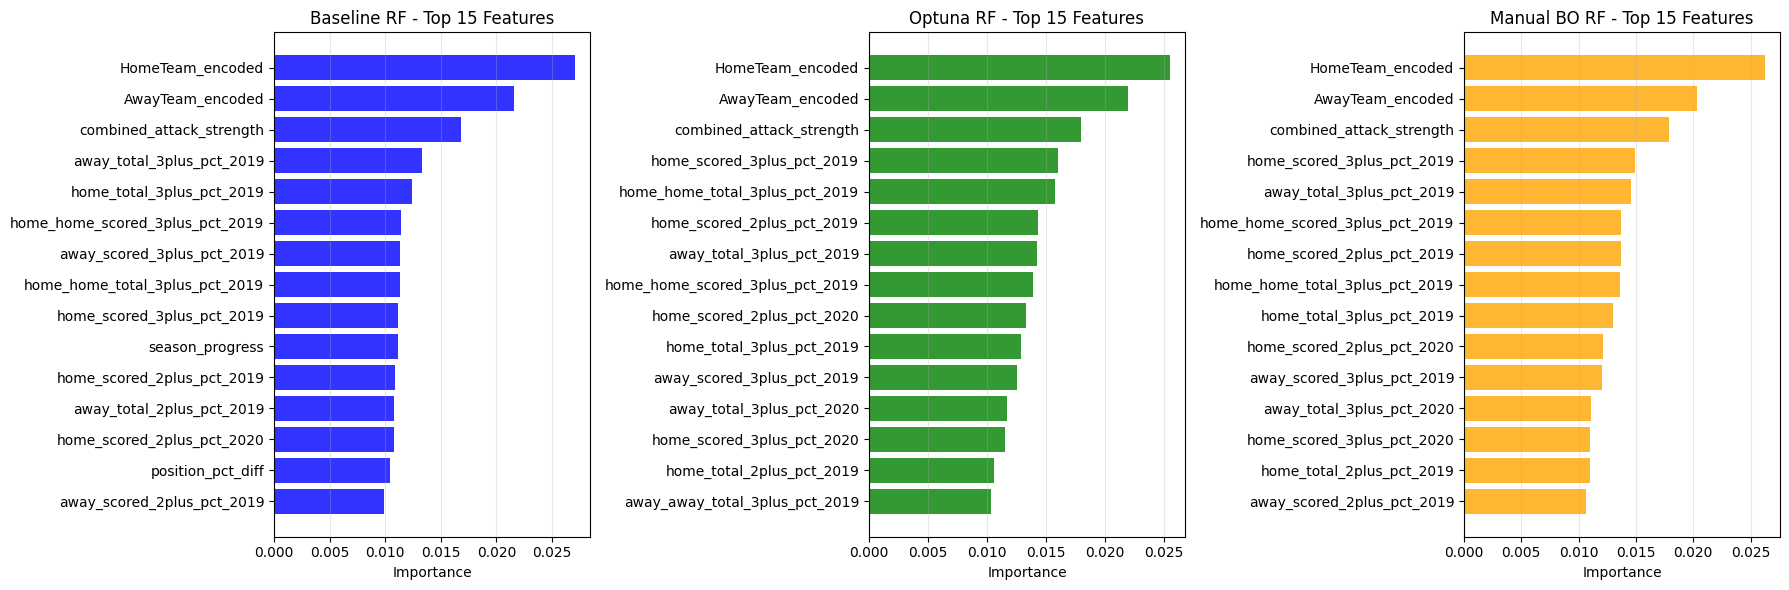


Top 10 Most Important Features (Optuna Model):
                        feature  importance
               HomeTeam_encoded    0.025500
               AwayTeam_encoded    0.021910
       combined_attack_strength    0.017950
     home_scored_3plus_pct_2019    0.015978
 home_home_total_3plus_pct_2019    0.015761
     home_scored_2plus_pct_2019    0.014330
      away_total_3plus_pct_2019    0.014271
home_home_scored_3plus_pct_2019    0.013888
     home_scored_2plus_pct_2020    0.013345
      home_total_3plus_pct_2019    0.012858


In [ ]:
# Compare feature importances across all three models
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

top_n = 15

# Baseline model
feature_importance_baseline = pd.DataFrame({
    'feature': X_train.columns,
    'importance': baseline_rf.feature_importances_
}).sort_values('importance', ascending=False)

axes[0].barh(range(top_n), feature_importance_baseline.head(top_n)['importance'], alpha=0.8, color='blue')
axes[0].set_yticks(range(top_n))
axes[0].set_yticklabels(feature_importance_baseline.head(top_n)['feature'])
axes[0].set_xlabel('Importance')
axes[0].set_title(f'Baseline RF - Top {top_n} Features')
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis='x')

# Optuna model
feature_importance_optuna = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_optuna.feature_importances_
}).sort_values('importance', ascending=False)

axes[1].barh(range(top_n), feature_importance_optuna.head(top_n)['importance'], alpha=0.8, color='green')
axes[1].set_yticks(range(top_n))
axes[1].set_yticklabels(feature_importance_optuna.head(top_n)['feature'])
axes[1].set_xlabel('Importance')
axes[1].set_title(f'Optuna RF - Top {top_n} Features')
axes[1].invert_yaxis()
axes[1].grid(True, alpha=0.3, axis='x')

# Manual BO model
feature_importance_manual = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_manual.feature_importances_
}).sort_values('importance', ascending=False)

axes[2].barh(range(top_n), feature_importance_manual.head(top_n)['importance'], alpha=0.8, color='orange')
axes[2].set_yticks(range(top_n))
axes[2].set_yticklabels(feature_importance_manual.head(top_n)['feature'])
axes[2].set_xlabel('Importance')
axes[2].set_title(f'Manual BO RF - Top {top_n} Features')
axes[2].invert_yaxis()
axes[2].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# Print top features for best model (let's say Optuna for now, but compare both)
print("\nTop 10 Most Important Features (Optuna Model):")
print(feature_importance_optuna.head(10).to_string(index=False))

### #3.2: Feature Importance Distribution Analysis
Analyze the distribution of feature importances and cumulative importance.

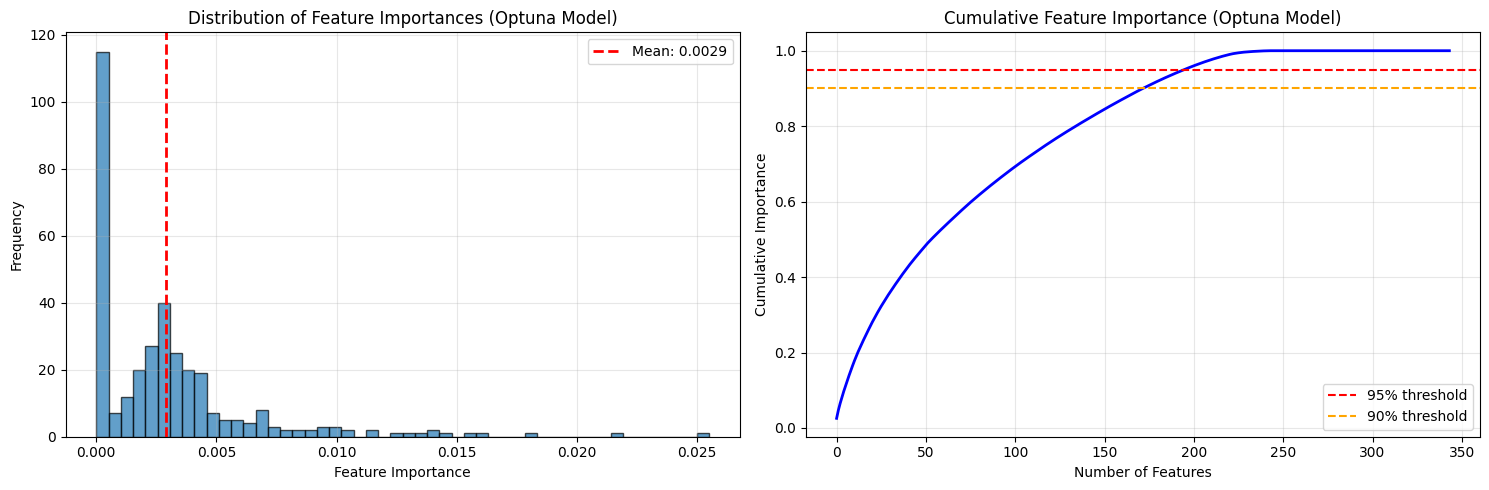


Feature Importance Summary (Optuna Model):
  Total features: 344
  Features capturing 90% importance: 173 (50.3%)
  Features capturing 95% importance: 196 (57.0%)


In [ ]:
# Use Optuna model for detailed analysis (best performing)
feature_importance = feature_importance_optuna.copy()

# Calculate cumulative importance
feature_importance['cumulative_importance'] = feature_importance['importance'].cumsum()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Importance distribution
ax1.hist(feature_importance['importance'], bins=50, alpha=0.7, edgecolor='black')
ax1.set_xlabel('Feature Importance')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Feature Importances (Optuna Model)')
ax1.axvline(feature_importance['importance'].mean(), color='red', linestyle='--', 
            linewidth=2, label=f'Mean: {feature_importance["importance"].mean():.4f}')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Cumulative importance
ax2.plot(range(len(feature_importance)), feature_importance['cumulative_importance'], 'b-', linewidth=2)
ax2.axhline(y=0.95, color='r', linestyle='--', label='95% threshold')
ax2.axhline(y=0.90, color='orange', linestyle='--', label='90% threshold')
ax2.set_xlabel('Number of Features')
ax2.set_ylabel('Cumulative Importance')
ax2.set_title('Cumulative Feature Importance (Optuna Model)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Report how many features capture 90% and 95% of importance
n_features_90 = (feature_importance['cumulative_importance'] <= 0.90).sum() + 1
n_features_95 = (feature_importance['cumulative_importance'] <= 0.95).sum() + 1

print(f"\nFeature Importance Summary (Optuna Model):")
print(f"  Total features: {len(feature_importance)}")
print(f"  Features capturing 90% importance: {n_features_90} ({n_features_90/len(feature_importance)*100:.1f}%)")
print(f"  Features capturing 95% importance: {n_features_95} ({n_features_95/len(feature_importance)*100:.1f}%)")

## #4: Learning Curves

### #4.1: Generate Learning Curves for All Models
Plot learning curves to analyze training vs validation performance and identify overfitting.

In [ ]:
def plot_learning_curve(model, X, y, title, cv=5):
    """
    Generate and plot learning curves for a model using log loss.
    """
    # For log loss scoring (lower is better)
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, 
        cv=cv,
        scoring='neg_log_loss',  # Negative log loss (higher is better for sklearn)
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        random_state=42
    )
    
    # Convert back to positive log loss (lower is better)
    train_scores = -train_scores
    val_scores = -val_scores
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                     val_scores_mean + val_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    plt.xlabel("Training Examples")
    plt.ylabel("Log Loss (lower is better)")
    plt.title(title)
    plt.legend(loc="best")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return train_scores_mean, val_scores_mean

# Combine training and validation sets for learning curves
X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])

# Generate learning curves for baseline model
print("Generating learning curves for baseline model...")
baseline_train_lc, baseline_val_lc = plot_learning_curve(
    baseline_rf, X_train_val, y_train_val, 
    "Learning Curve - Baseline Random Forest"
)

Generating learning curves for baseline model...


NameError: name 'baseline_rf' is not defined

Generating learning curves for Optuna optimized model...


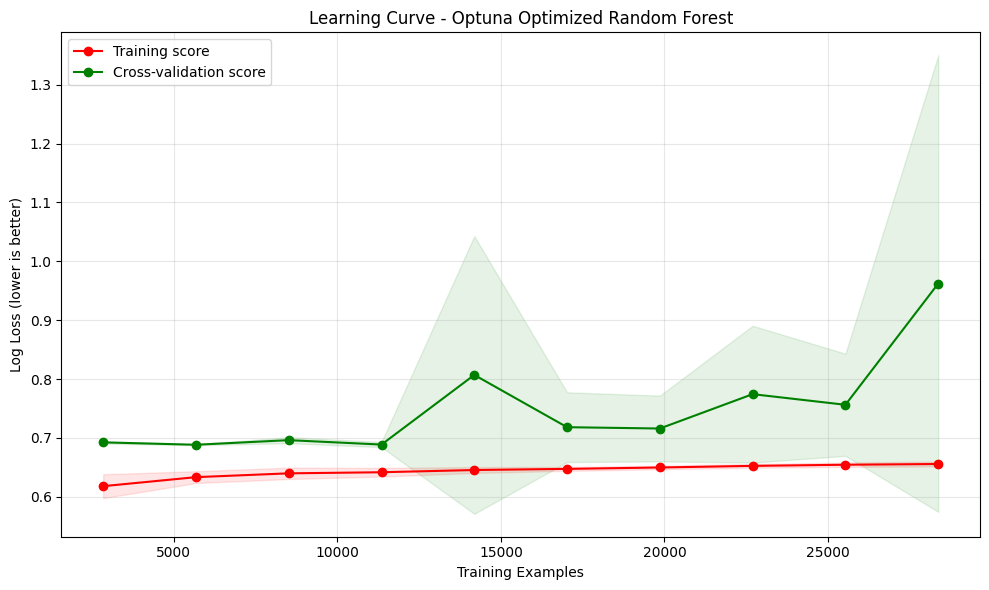

In [65]:
# Generate learning curves for Optuna model
print("Generating learning curves for Optuna optimized model...")
optuna_train_lc, optuna_val_lc = plot_learning_curve(
    rf_optuna, X_train_val, y_train_val, 
    "Learning Curve - Optuna Optimized Random Forest"
)

Generating learning curves for Manual BO optimized model...


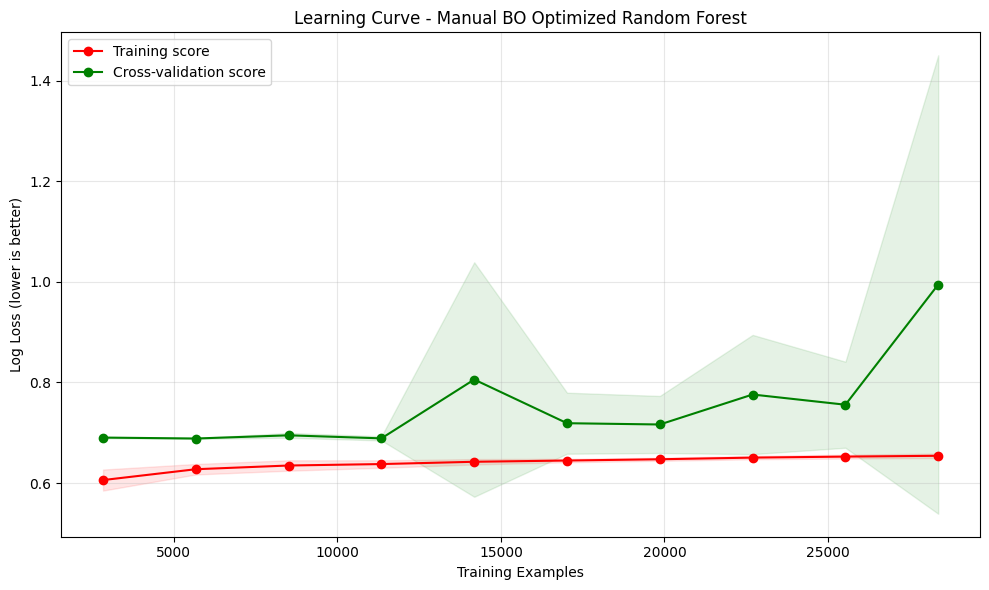

In [66]:
# Generate learning curves for Manual BO model
print("Generating learning curves for Manual BO optimized model...")
manual_train_lc, manual_val_lc = plot_learning_curve(
    rf_manual, X_train_val, y_train_val, 
    "Learning Curve - Manual BO Optimized Random Forest"
)

## #5: Final Evaluation on Test Set

### #5.1: Evaluate All Models on Test Set
Test all three models (Baseline, Optuna, Manual BO) on the held-out test set to get final performance metrics.

In [ ]:
# Evaluate all models on test set
print("Evaluating all models on test set...")
baseline_test_results = evaluate_model(baseline_rf, X_test, y_test, "Baseline - Test Set")
optuna_test_results = evaluate_model(rf_optuna, X_test, y_test, "Optuna Optimized - Test Set")
manual_test_results = evaluate_model(rf_manual, X_test, y_test, "Manual  BO Optimized - Test Set")

Evaluating all models on test set...

Performance Metrics - Baseline - Test Set
Accuracy:  0.5447
Precision: 0.5453
Recall:    0.5447
F1-Score:  0.5444
ROC-AUC:   0.5653
Log Loss:  0.6871

Confusion Matrix:
[[2006 1509]
 [1737 1877]]

Classification Report:
              precision    recall  f1-score   support

   Under 2.5       0.54      0.57      0.55      3515
    Over 2.5       0.55      0.52      0.54      3614

    accuracy                           0.54      7129
   macro avg       0.55      0.55      0.54      7129
weighted avg       0.55      0.54      0.54      7129



[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished



Performance Metrics - Optuna Optimized - Test Set
Accuracy:  0.5499
Precision: 0.5511
Recall:    0.5499
F1-Score:  0.5489
ROC-AUC:   0.5665
Log Loss:  0.6855

Confusion Matrix:
[[2103 1412]
 [1797 1817]]

Classification Report:
              precision    recall  f1-score   support

   Under 2.5       0.54      0.60      0.57      3515
    Over 2.5       0.56      0.50      0.53      3614

    accuracy                           0.55      7129
   macro avg       0.55      0.55      0.55      7129
weighted avg       0.55      0.55      0.55      7129


Performance Metrics - Manual BO Optimized - Test Set
Accuracy:  0.5496
Precision: 0.5508
Recall:    0.5496
F1-Score:  0.5486
ROC-AUC:   0.5669
Log Loss:  0.6855

Confusion Matrix:
[[2101 1414]
 [1797 1817]]

Classification Report:
              precision    recall  f1-score   support

   Under 2.5       0.54      0.60      0.57      3515
    Over 2.5       0.56      0.50      0.53      3614

    accuracy                           0.55     

### #5.2: Compare All Models on Test Set
Compare baseline and both optimized models' performance on the test set with comprehensive metrics.

In [68]:
# Create comprehensive test set comparison
test_comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'Log Loss'],
    'Baseline': [
        baseline_test_results['accuracy'],
        baseline_test_results['precision'],
        baseline_test_results['recall'],
        baseline_test_results['f1'],
        baseline_test_results['roc_auc'],
        baseline_test_results['log_loss']
    ],
    'Optuna': [
        optuna_test_results['accuracy'],
        optuna_test_results['precision'],
        optuna_test_results['recall'],
        optuna_test_results['f1'],
        optuna_test_results['roc_auc'],
        optuna_test_results['log_loss']
    ],
    'Manual BO': [
        manual_test_results['accuracy'],
        manual_test_results['precision'],
        manual_test_results['recall'],
        manual_test_results['f1'],
        manual_test_results['roc_auc'],
        manual_test_results['log_loss']
    ]
})

# Calculate improvement percentages
test_comparison_df['Optuna Improvement (%)'] = ((test_comparison_df['Optuna'] - test_comparison_df['Baseline']) / test_comparison_df['Baseline'] * 100).round(2)
test_comparison_df['Manual BO Improvement (%)'] = ((test_comparison_df['Manual BO'] - test_comparison_df['Baseline']) / test_comparison_df['Baseline'] * 100).round(2)

# For Log Loss, invert the improvement calculation (reduction is improvement)
log_loss_idx = test_comparison_df['Metric'] == 'Log Loss'
test_comparison_df.loc[log_loss_idx, 'Optuna Improvement (%)'] = (
    ((test_comparison_df.loc[log_loss_idx, 'Baseline'].values - test_comparison_df.loc[log_loss_idx, 'Optuna'].values) / 
     test_comparison_df.loc[log_loss_idx, 'Baseline'].values * 100).round(2)[0]
)
test_comparison_df.loc[log_loss_idx, 'Manual BO Improvement (%)'] = (
    ((test_comparison_df.loc[log_loss_idx, 'Baseline'].values - test_comparison_df.loc[log_loss_idx, 'Manual BO'].values) / 
     test_comparison_df.loc[log_loss_idx, 'Baseline'].values * 100).round(2)[0]
)

print("\n" + "="*80)
print("TEST SET COMPARISON: Baseline vs Optuna vs Manual BO")
print("="*80)
print(test_comparison_df.to_string(index=False))
print("="*80)


TEST SET COMPARISON: Baseline vs Optuna vs Manual BO
   Metric  Baseline   Optuna  Manual BO  Optuna Improvement (%)  Manual BO Improvement (%)
 Accuracy  0.544677 0.549867   0.549586                    0.95                       0.90
Precision  0.545265 0.551135   0.550842                    1.08                       1.02
   Recall  0.544677 0.549867   0.549586                    0.95                       0.90
 F1-Score  0.544413 0.548890   0.548621                    0.82                       0.77
  ROC-AUC  0.565271 0.566542   0.566902                    0.22                       0.29
 Log Loss  0.687147 0.685533   0.685520                    0.23                       0.24


### #5.3: Visualize Test Set Performance
Visualize comparison of all three models on the test set with charts and confusion matrices.

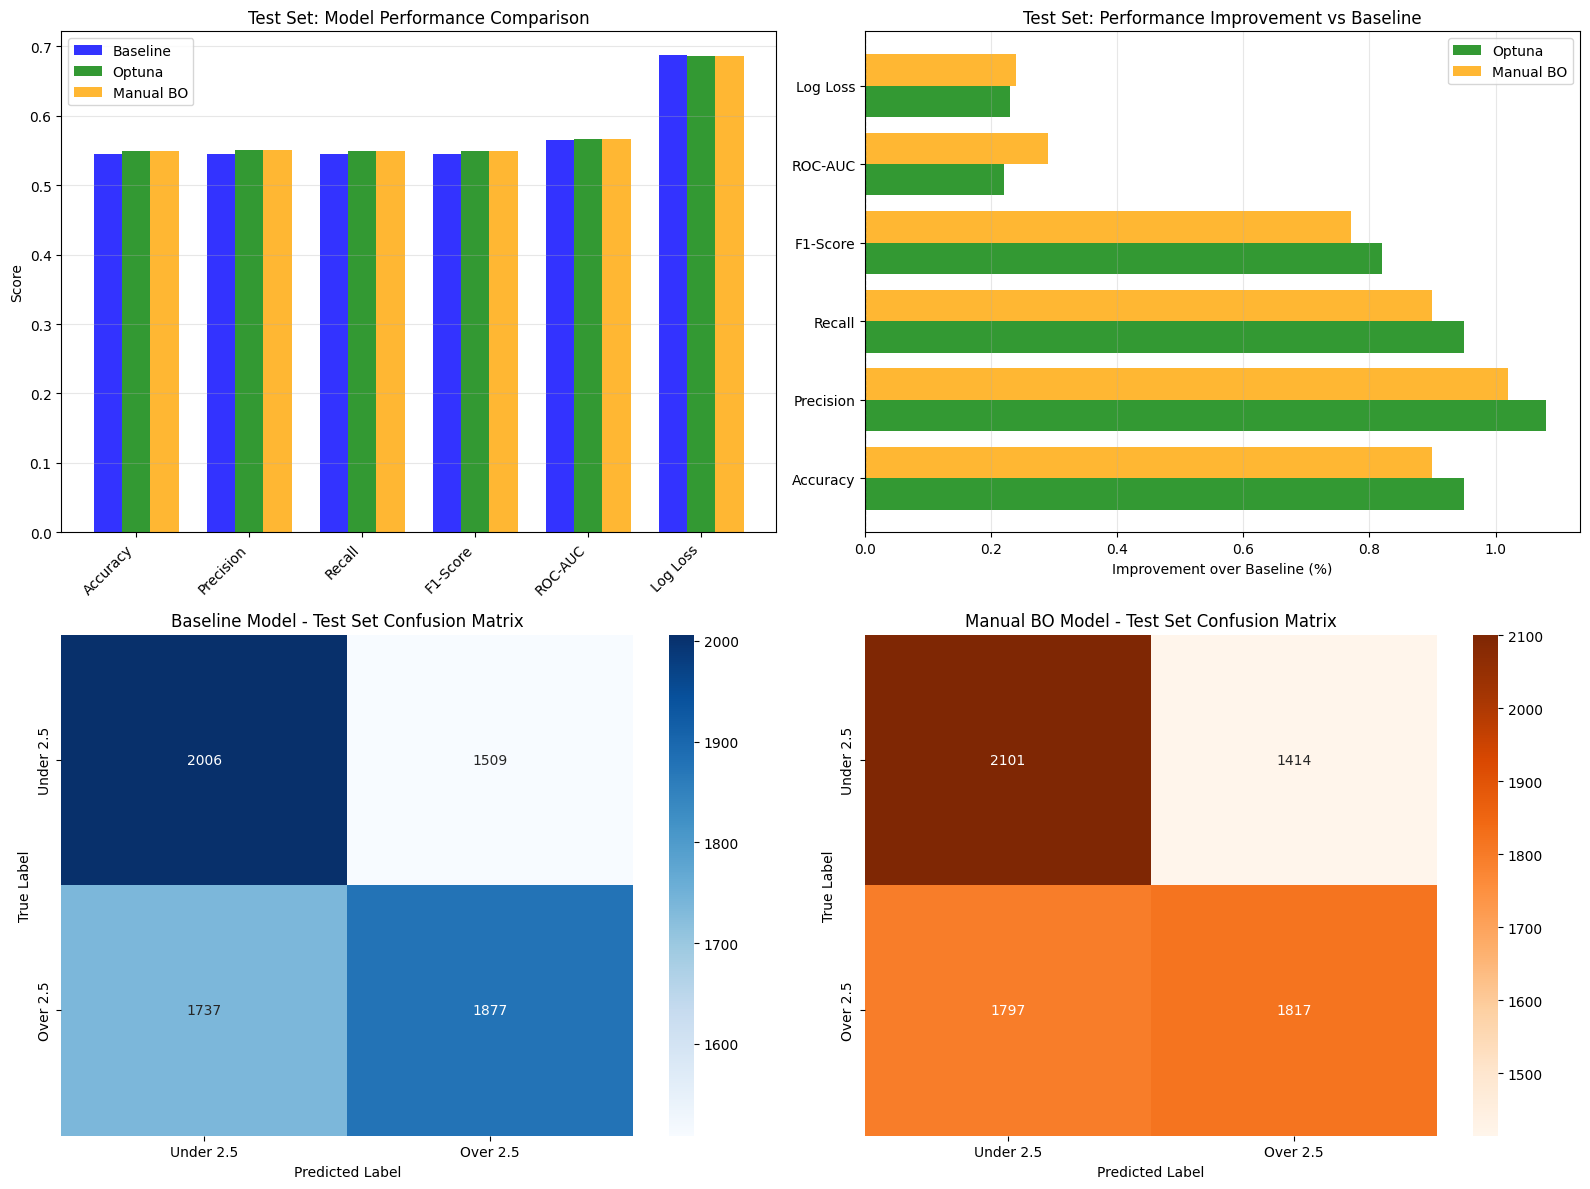

In [69]:
# Visualize test set results with all three models
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Metrics comparison bar plot
metrics = test_comparison_df['Metric'].tolist()
x = np.arange(len(metrics))
width = 0.25

axes[0, 0].bar(x - width, test_comparison_df['Baseline'], width, label='Baseline', alpha=0.8, color='blue')
axes[0, 0].bar(x, test_comparison_df['Optuna'], width, label='Optuna', alpha=0.8, color='green')
axes[0, 0].bar(x + width, test_comparison_df['Manual BO'], width, label='Manual BO', alpha=0.8, color='orange')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_title('Test Set: Model Performance Comparison')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(metrics, rotation=45, ha='right')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')

# 2. Improvement percentage comparison
improvement_data = pd.DataFrame({
    'Metric': metrics,
    'Optuna': test_comparison_df['Optuna Improvement (%)'],
    'Manual BO': test_comparison_df['Manual BO Improvement (%)']
})

x_pos = np.arange(len(metrics))
axes[0, 1].barh(x_pos - 0.2, improvement_data['Optuna'], 0.4, label='Optuna', alpha=0.8, color='green')
axes[0, 1].barh(x_pos + 0.2, improvement_data['Manual BO'], 0.4, label='Manual BO', alpha=0.8, color='orange')
axes[0, 1].set_yticks(x_pos)
axes[0, 1].set_yticklabels(metrics)
axes[0, 1].set_xlabel('Improvement over Baseline (%)')
axes[0, 1].set_title('Test Set: Performance Improvement vs Baseline')
axes[0, 1].axvline(x=0, color='black', linestyle='--', linewidth=0.8)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='x')

# 3. Baseline confusion matrix
sns.heatmap(baseline_test_results['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
            xticklabels=['Under 2.5', 'Over 2.5'], yticklabels=['Under 2.5', 'Over 2.5'],
            ax=axes[1, 0])
axes[1, 0].set_title('Baseline Model - Test Set Confusion Matrix')
axes[1, 0].set_ylabel('True Label')
axes[1, 0].set_xlabel('Predicted Label')

# 4. Best optimized model confusion matrix (choose best between Optuna and Manual BO based on log loss)
best_model_name = 'Optuna' if optuna_test_results['log_loss'] <= manual_test_results['log_loss'] else 'Manual BO'
best_model_results = optuna_test_results if best_model_name == 'Optuna' else manual_test_results
best_model_color = 'Greens' if best_model_name == 'Optuna' else 'Oranges'

sns.heatmap(best_model_results['confusion_matrix'], annot=True, fmt='d', cmap=best_model_color,
            xticklabels=['Under 2.5', 'Over 2.5'], yticklabels=['Under 2.5', 'Over 2.5'],
            ax=axes[1, 1])
axes[1, 1].set_title(f'{best_model_name} Model - Test Set Confusion Matrix')
axes[1, 1].set_ylabel('True Label')
axes[1, 1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

### #5.4: Performance Summary Across All Sets
Compare model performance across validation and test sets.


PERFORMANCE SUMMARY - VALIDATION AND TEST SETS
   Dataset     Model  Accuracy  F1-Score  ROC-AUC  Log Loss
Validation  Baseline  0.559404  0.559537 0.578553  0.683520
      Test  Baseline  0.544677  0.544413 0.565271  0.687147
Validation    Optuna  0.556092  0.555699 0.583740  0.682275
      Test    Optuna  0.549867  0.548890 0.566542  0.685533
Validation Manual BO  0.556644  0.556050 0.582266  0.682849
      Test Manual BO  0.549586  0.548621 0.566902  0.685520


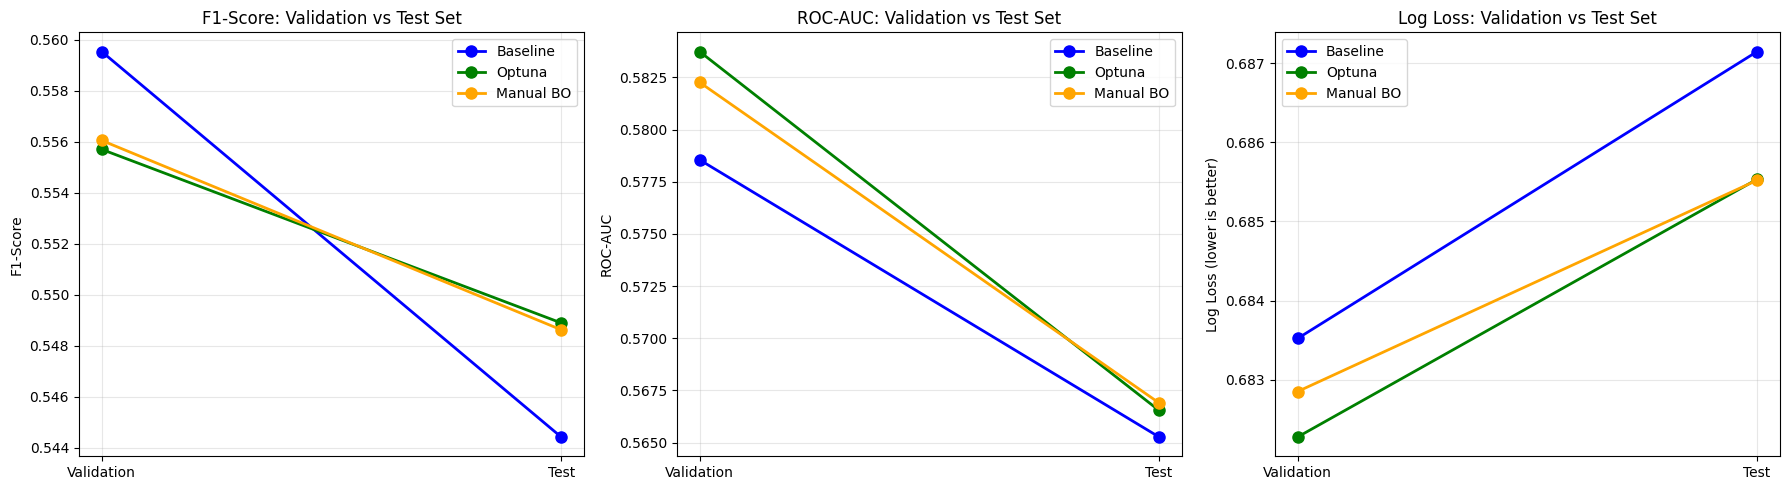

In [70]:
# Create comprehensive summary across all datasets
summary_data = {
    'Dataset': ['Validation', 'Test'] * 3,
    'Model': ['Baseline'] * 2 + ['Optuna'] * 2 + ['Manual BO'] * 2,
    'Accuracy': [
        baseline_val_results['accuracy'],
        baseline_test_results['accuracy'],
        optuna_val_results['accuracy'],
        optuna_test_results['accuracy'],
        manual_val_results['accuracy'],
        manual_test_results['accuracy']
    ],
    'F1-Score': [
        baseline_val_results['f1'],
        baseline_test_results['f1'],
        optuna_val_results['f1'],
        optuna_test_results['f1'],
        manual_val_results['f1'],
        manual_test_results['f1']
    ],
    'ROC-AUC': [
        baseline_val_results['roc_auc'],
        baseline_test_results['roc_auc'],
        optuna_val_results['roc_auc'],
        optuna_test_results['roc_auc'],
        manual_val_results['roc_auc'],
        manual_test_results['roc_auc']
    ],
    'Log Loss': [
        baseline_val_results['log_loss'],
        baseline_test_results['log_loss'],
        optuna_val_results['log_loss'],
        optuna_test_results['log_loss'],
        manual_val_results['log_loss'],
        manual_test_results['log_loss']
    ]
}

summary_df = pd.DataFrame(summary_data)

print("\n" + "="*80)
print("PERFORMANCE SUMMARY - VALIDATION AND TEST SETS")
print("="*80)
print(summary_df.to_string(index=False))
print("="*80)

# Plot performance across datasets
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# F1-Score across datasets
datasets = ['Validation', 'Test']
baseline_f1 = [baseline_val_results['f1'], baseline_test_results['f1']]
optuna_f1 = [optuna_val_results['f1'], optuna_test_results['f1']]
manual_f1 = [manual_val_results['f1'], manual_test_results['f1']]

axes[0].plot(datasets, baseline_f1, 'o-', linewidth=2, markersize=8, label='Baseline', color='blue')
axes[0].plot(datasets, optuna_f1, 'o-', linewidth=2, markersize=8, label='Optuna', color='green')
axes[0].plot(datasets, manual_f1, 'o-', linewidth=2, markersize=8, label='Manual BO', color='orange')
axes[0].set_ylabel('F1-Score')
axes[0].set_title('F1-Score: Validation vs Test Set')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# ROC-AUC across datasets
baseline_auc = [baseline_val_results['roc_auc'], baseline_test_results['roc_auc']]
optuna_auc = [optuna_val_results['roc_auc'], optuna_test_results['roc_auc']]
manual_auc = [manual_val_results['roc_auc'], manual_test_results['roc_auc']]

axes[1].plot(datasets, baseline_auc, 'o-', linewidth=2, markersize=8, label='Baseline', color='blue')
axes[1].plot(datasets, optuna_auc, 'o-', linewidth=2, markersize=8, label='Optuna', color='green')
axes[1].plot(datasets, manual_auc, 'o-', linewidth=2, markersize=8, label='Manual BO', color='orange')
axes[1].set_ylabel('ROC-AUC')
axes[1].set_title('ROC-AUC: Validation vs Test Set')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Log Loss across datasets (lower is better)
baseline_logloss = [baseline_val_results['log_loss'], baseline_test_results['log_loss']]
optuna_logloss = [optuna_val_results['log_loss'], optuna_test_results['log_loss']]
manual_logloss = [manual_val_results['log_loss'], manual_test_results['log_loss']]

axes[2].plot(datasets, baseline_logloss, 'o-', linewidth=2, markersize=8, label='Baseline', color='blue')
axes[2].plot(datasets, optuna_logloss, 'o-', linewidth=2, markersize=8, label='Optuna', color='green')
axes[2].plot(datasets, manual_logloss, 'o-', linewidth=2, markersize=8, label='Manual BO', color='orange')
axes[2].set_ylabel('Log Loss (lower is better)')
axes[2].set_title('Log Loss: Validation vs Test Set')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### #5.5: Save Best Models and Results
Save the optimized models and best parameters for future use.

In [71]:
# Determine best model based on test set Log Loss (lower is better)
import joblib

best_model_name = 'Optuna' if optuna_test_results['log_loss'] <= manual_test_results['log_loss'] else 'Manual BO'
best_model = rf_optuna if best_model_name == 'Optuna' else rf_manual
best_params_final = study.best_params if best_model_name == 'Optuna' else manual_bo_params
best_test_logloss = optuna_test_results['log_loss'] if best_model_name == 'Optuna' else manual_test_results['log_loss']

print(f"\nBest Model: {best_model_name} (Test Log Loss: {best_test_logloss:.6f})")

# Save all results in a single comprehensive file
results_save_path = './outputs/models/baseline_rf_results.pkl'
results_dict = {
    # Evaluation results
    'baseline_val': baseline_val_results,
    'baseline_test': baseline_test_results,
    'optuna_val': optuna_val_results,
    'optuna_test': optuna_test_results,
    'manual_val': manual_val_results,
    'manual_test': manual_test_results,
    
    # Models
    'baseline_model': baseline_rf,
    'optuna_model': rf_optuna,
    'manual_bo_model': rf_manual,
    'best_model': best_model,
    'best_model_name': best_model_name,
    
    # Parameters
    'optuna_params': study.best_params,
    'manual_bo_params': manual_bo_params,
    'best_params': best_params_final,
    
    # Analysis
    'feature_importance': feature_importance,
    'optuna_study': study
}
joblib.dump(results_dict, results_save_path)
print(f"\nAll models, parameters, and results saved to: {results_save_path}")
print(f"   - Baseline, Optuna, and Manual BO models")
print(f"   - All hyperparameters and optimization history")
print(f"   - Feature importance analysis")
print(f"   - Validation and test set results")

print("\n" + "="*80)
print(f"BEST MODEL CONFIGURATION ({best_model_name})")
print("="*80)
for key, value in best_params_final.items():
    print(f"  {key}: {value}")
print("="*80)


Best Model: Manual BO (Test Log Loss: 0.685520)

All models, parameters, and results saved to: ./outputs/models/baseline_rf_results.pkl
   - Baseline, Optuna, and Manual BO models
   - All hyperparameters and optimization history
   - Feature importance analysis
   - Validation and test set results

BEST MODEL CONFIGURATION (Manual BO)
  n_estimators: 491
  max_depth: 8
  min_samples_split: 12
  min_samples_leaf: 1
  max_features: log2
  bootstrap: False
